# Dataset: Simple Split

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils as torch_utils
import numpy as np

import random
import math
import time

In [ ]:
import pandas as pd
import numpy as np
import requests
from io import StringIO
from concurrent.futures import ThreadPoolExecutor

def download_file(file_url):
    response = requests.get(file_url)
    if response.status_code == 200:
        return response.text
    else:
        print(f"Failed to fetch the file. Status code: {response.status_code}")
        return None

# URLs of the files you want to download
file_urls = [
    'https://raw.githubusercontent.com/brendenlake/SCAN/master/simple_split/tasks_train_simple.txt',
    'https://raw.githubusercontent.com/brendenlake/SCAN/master/simple_split/tasks_test_simple.txt'  # Replace with the actual URL of the second file
]

# Use ThreadPoolExecutor to download files concurrently
with ThreadPoolExecutor(max_workers=len(file_urls)) as executor:
    results = list(executor.map(download_file, file_urls))

# Check if all downloads were successful
if all(result is not None for result in results):
    # Assuming each line in the text file is a sentence
    sentences_list = [result.split('\n') for result in results]

    # Create DataFrames for each file
    dfs = [pd.DataFrame({'Sentences': sentences}) for sentences in sentences_list]

    # Create DataFrames for each file
    train_df = pd.DataFrame({'Sentences': sentences_list[0]})
    eval_df = pd.DataFrame({'Sentences': sentences_list[1]})
else:
    print("One or more downloads failed.")

In [ ]:
print(train_df.head())

                                           Sentences
0  IN: jump opposite right twice and turn opposit...
1  IN: run opposite left after walk right OUT: I_...
2  IN: walk after run around right twice OUT: I_T...
3  IN: look around right thrice and turn left OUT...
4  IN: walk opposite left twice and walk opposite...


In [ ]:
SEED = 5392

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from torch.utils.data import Dataset

class SentenceDataset(Dataset):
   def __init__(self, sentences):
       self.sentences = sentences

   def __len__(self):
       return len(self.sentences)

   def __getitem__(self, idx):
       sentence = self.sentences[idx]
       in_sentence = sentence.split('IN:')[1].split('OUT:')[0].strip()
       out_sentence = sentence.split('OUT:')[1].strip()
       return [in_sentence, out_sentence]

In [ ]:
train_set = SentenceDataset(train_df['Sentences'])
eval_set = SentenceDataset(eval_df['Sentences'])

In [ ]:
PAD_token = 0
SOS_token = 1
EOS_token = 2

class Vocab:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "PAD", 1: "SOS", 2: "EOS"}
        self.n_words = 3  # Count PAD SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [ ]:
def indexesFromSentence(vocab, sentence):
    return [vocab.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)


In [ ]:
input_vocab = Vocab('IN')
output_vocab = Vocab('OUT')
for line in train_set:
    input_vocab.addSentence(line[0])
    output_vocab.addSentence(line[1])

In [ ]:
print(input_vocab.word2index)
print(input_vocab.index2word)


{'jump': 3, 'opposite': 4, 'right': 5, 'twice': 6, 'and': 7, 'turn': 8, 'thrice': 9, 'run': 10, 'left': 11, 'after': 12, 'walk': 13, 'around': 14, 'look': 15}
{0: 'PAD', 1: 'SOS', 2: 'EOS', 3: 'jump', 4: 'opposite', 5: 'right', 6: 'twice', 7: 'and', 8: 'turn', 9: 'thrice', 10: 'run', 11: 'left', 12: 'after', 13: 'walk', 14: 'around', 15: 'look'}


# DATALOADER

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, dataset, in_voacab, out_vocab):
        self.dataset = dataset
        self.in_vocab = in_voacab
        self.out_vocab = out_vocab
        input_sentences = []
        target_sentences = []
        for line in self.dataset:
            input_sentences.append(line[0])
            target_sentences.append(line[1])
        self.input_sentences = input_sentences
        self.target_sentences = target_sentences


    def __len__(self):
        return len(self.input_sentences)

    def __getitem__(self, idx):
        input_sentence = self.input_sentences[idx]
        target_sentence = self.target_sentences[idx]

        # Convert words to indices using word2index dictionary
        input_indices = indexesFromSentence(self.in_vocab, input_sentence)
        input_indices.append(EOS_token)
        target_indices = indexesFromSentence(self.out_vocab, target_sentence)
        target_indices.append(EOS_token)

        return torch.LongTensor(input_indices).to(device), torch.LongTensor(target_indices).to(device)


# LSTM encoder decoder

In [ ]:
import torch.nn as nn


class EncoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.5):
        super(EncoderLSTM, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.LSTM = nn.LSTM(hidden_size, hidden_size, num_layers=2, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))

        output, hidden = self.LSTM(embedded)
        return output, hidden


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class DecoderLSTM(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.5):
        super(DecoderLSTM, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.LSTM = nn.LSTM(hidden_size, hidden_size, num_layers=2, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, epoch=0, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        #print("decoder input", decoder_input)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        if target_tensor is not None:
            target_len = target_tensor.size(1)
        else:
            target_len = 49
        #print("target len:", trg_len)
        #print("decoder hidden", decoder_hidden)

        for i in range(target_len):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)
            #print("decoder single output", decoder_output)
            if target_tensor is not None and epoch < 50000:
                # Teacher forcing: Feed the target as the next input
                #print("target tensor", target_tensor)
                #print("epoch:", epoch)
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
                #print("Decoder input case 1 (target)", decoder_input)
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input
                #print("Decoder input case 2 (topi)", decoder_input)

        #print("decoder outputs", decoder_outputs)
        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.dropout(self.embedding(input))
        output = F.relu(output)
        output, hidden = self.LSTM(output, hidden)
        output = self.out(output)
        return output, hidden

# Train encoder decoder

In [ ]:
import torch.nn.utils as torch_utils

def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion, epoch, max_norm=5.0):

    total_loss = 0

    input_tensor, target_tensor = next(iter(dataloader))
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    encoder_outputs, encoder_hidden = encoder(input_tensor)
    decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, epoch,target_tensor)

    #print("Decoder that get passed =", decoder_outputs.view(-1, decoder_outputs.size(-1)))
    #print("target_tensor that get passed =", target_tensor.view(-1))
    loss = criterion(
        decoder_outputs.view(-1, decoder_outputs.size(-1)),
        target_tensor.view(-1)
    )

    #print("decoder_outputs", decoder_outputs)
    #print("target_tensor", target_tensor)
    loss.backward()

    # Gradient clipping for both encoder and decoder
    torch_utils.clip_grad_norm_(encoder.parameters(), max_norm)
    torch_utils.clip_grad_norm_(decoder.parameters(), max_norm)

    encoder_optimizer.step()
    decoder_optimizer.step()

    total_loss += loss.item()

    return total_loss
    #return total_loss / len(dataloader)

In [ ]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [ ]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, epoch)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [ ]:
def evaluate(encoder, decoder, test_sentences, input_lang, output_lang):
    success = 0
    success_partial = 0
    with torch.no_grad():
      for i in range(len(test_sentences)):
          print(i)
          input_sentence = test_sentences[i][0]
          input_tensor = tensorFromSentence(input_lang, input_sentence)

          encoder_outputs, encoder_hidden = encoder(input_tensor)
          decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden, epoch=1)

          _, topi = decoder_outputs.topk(1)
          decoded_ids = topi.squeeze()

          decoded_words = []
          for idx in decoded_ids:
              if idx.item() == EOS_token:
                  break
              decoded_words.append(output_lang.index2word[idx.item()])
          #check exact match between decoded_words and test_dataset[i][1]
          #print("Expected output: " + test_sentences[i][1])
          #print("Predicted output: " + " ".join(decoded_words))

          #check exact match
          if (decoded_words == test_sentences[i][1].split()):
              success = success + 1
              print("succes ", success, "out of", i+1)
          #check partial match
          if (test_sentences[i][1] in " ".join(decoded_words)):
              success_partial = success_partial + 1
              print("partial succes ", success_partial, "out of", i+1)


    print(f"Exact match accuracy: {success / len(test_sentences) * 100:.2f}%")
    print(f"Partial match accuracy: {success_partial / len(test_sentences) * 100:.2f}%")
    return (success / len(test_sentences) * 100)

# Experiment 1

In [ ]:
indexes_001 = random.sample(range(len(train_set)), 210)
train_set_001= [train_set[i] for i in indexes_001]

indexes_002 = random.sample(range(len(train_set)-1), 420)
train_set_002= [train_set[i] for i in indexes_002]
print(len(indexes_001))
print(len(set(indexes_001)))

indexes_004 = random.sample(range(len(train_set)-1), 840)
train_set_004= [train_set[i] for i in indexes_004]

indexes_008 = random.sample(range(len(train_set)-1), int(len(train_set)*0.08))
train_set_008= [train_set[i] for i in indexes_008]

indexes_016 = random.sample(range(len(train_set)-1), int(len(train_set)*0.16))
train_set_016= [train_set[i] for i in indexes_016]

indexes_032 = random.sample(range(len(train_set)-1), int(len(train_set)*0.32))
train_set_032= [train_set[i] for i in indexes_032]

indexes_64 = random.sample(range(len(train_set)-1), int(len(train_set)*0.64))
train_set_64= [train_set[i] for i in indexes_64]

210
210


1%

In [ ]:
hidden_size = 200
batch_size = 1

train_dataset = CustomDataset(train_set_001, input_vocab, output_vocab)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

encoder = EncoderLSTM(input_vocab.n_words, hidden_size).to(device)
decoder = DecoderLSTM(hidden_size, output_vocab.n_words).to(device)

train(train_dataloader, encoder, decoder, 100000, print_every=100, plot_every=500)

KeyboardInterrupt: ignored

In [ ]:
results = []

In [ ]:
eval = [eval_set[i] for i in range(4182)]
encoder.eval()
decoder.eval()
result001 = evaluate(encoder, decoder, eval, input_vocab, output_vocab)
results.append(result001)

2%

In [ ]:
hidden_size = 200
batch_size = 1

train_dataset = CustomDataset(train_set_002, input_vocab, output_vocab)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

encoder = EncoderLSTM(input_vocab.n_words, hidden_size).to(device)
decoder = DecoderLSTM(hidden_size, output_vocab.n_words).to(device)


train(train_dataloader, encoder, decoder, 100000, print_every=1000, plot_every=500)

1m 39s (- 163m 52s) (1000 1%) 0.9827
3m 16s (- 160m 43s) (2000 2%) 0.5143
4m 55s (- 159m 19s) (3000 3%) 0.3329
6m 29s (- 155m 41s) (4000 4%) 0.2397
8m 4s (- 153m 21s) (5000 5%) 0.1824
9m 39s (- 151m 24s) (6000 6%) 0.1384
11m 13s (- 149m 10s) (7000 7%) 0.1247
12m 53s (- 148m 19s) (8000 8%) 0.1110
14m 33s (- 147m 7s) (9000 9%) 0.0951
16m 16s (- 146m 27s) (10000 10%) 0.0742
17m 55s (- 145m 3s) (11000 11%) 0.0708
19m 27s (- 142m 44s) (12000 12%) 0.0624
21m 3s (- 140m 54s) (13000 13%) 0.0653
22m 41s (- 139m 21s) (14000 14%) 0.0545
24m 22s (- 138m 5s) (15000 15%) 0.0536
26m 0s (- 136m 34s) (16000 16%) 0.0415
27m 44s (- 135m 28s) (17000 17%) 0.0397
29m 29s (- 134m 20s) (18000 18%) 0.0399
31m 17s (- 133m 25s) (19000 19%) 0.0403
33m 8s (- 132m 34s) (20000 20%) 0.0324
34m 54s (- 131m 20s) (21000 21%) 0.0288
36m 43s (- 130m 11s) (22000 22%) 0.0237
38m 30s (- 128m 53s) (23000 23%) 0.0387
40m 12s (- 127m 20s) (24000 24%) 0.0277
41m 54s (- 125m 42s) (25000 25%) 0.0243
43m 34s (- 124m 0s) (26000 26%)

In [ ]:
eval = [eval_set[i] for i in range(4182)]
encoder.eval()
decoder.eval()
result002 = evaluate(encoder, decoder, eval, input_vocab, output_vocab)
results.append(result002)

Streaming output truncated to the last 5000 lines.
succes  758 out of 1671
partial succes  904 out of 1671
1671
succes  759 out of 1672
partial succes  905 out of 1672
1672
succes  760 out of 1673
partial succes  906 out of 1673
1673
1674
1675
succes  761 out of 1676
partial succes  907 out of 1676
1676
succes  762 out of 1677
partial succes  908 out of 1677
1677
1678
succes  763 out of 1679
partial succes  909 out of 1679
1679
partial succes  910 out of 1680
1680
1681
1682
succes  764 out of 1683
partial succes  911 out of 1683
1683
succes  765 out of 1684
partial succes  912 out of 1684
1684
partial succes  913 out of 1685
1685
succes  766 out of 1686
partial succes  914 out of 1686
1686
partial succes  915 out of 1687
1687
1688
succes  767 out of 1689
partial succes  916 out of 1689
1689
succes  768 out of 1690
partial succes  917 out of 1690
1690
succes  769 out of 1691
partial succes  918 out of 1691
1691
succes  770 out of 1692
partial succes  919 out of 1692
1692
succes  771 out

4%

In [ ]:
hidden_size = 200
batch_size = 1

train_dataset = CustomDataset(train_set_004, input_vocab, output_vocab)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

encoder = EncoderLSTM(input_vocab.n_words, hidden_size).to(device)
decoder = DecoderLSTM(hidden_size, output_vocab.n_words).to(device)

train(train_dataloader, encoder, decoder, 100000, print_every=1000, plot_every=500)

1m 37s (- 160m 14s) (1000 1%) 0.9969
3m 21s (- 164m 34s) (2000 2%) 0.5342
5m 3s (- 163m 47s) (3000 3%) 0.3730
6m 44s (- 161m 53s) (4000 4%) 0.2843
8m 26s (- 160m 19s) (5000 5%) 0.2383
10m 5s (- 158m 6s) (6000 6%) 0.1849
11m 45s (- 156m 16s) (7000 7%) 0.1553
13m 27s (- 154m 45s) (8000 8%) 0.1276
15m 12s (- 153m 41s) (9000 9%) 0.1190
16m 56s (- 152m 26s) (10000 10%) 0.1001
18m 39s (- 150m 55s) (11000 11%) 0.0968
20m 21s (- 149m 20s) (12000 12%) 0.0782
22m 5s (- 147m 53s) (13000 13%) 0.0727
23m 46s (- 146m 3s) (14000 14%) 0.0729
25m 30s (- 144m 30s) (15000 15%) 0.0602
27m 15s (- 143m 5s) (16000 16%) 0.0510
28m 59s (- 141m 30s) (17000 17%) 0.0616
30m 50s (- 140m 30s) (18000 18%) 0.0504
32m 39s (- 139m 13s) (19000 19%) 0.0406
34m 30s (- 138m 1s) (20000 20%) 0.0462
36m 20s (- 136m 43s) (21000 21%) 0.0301
38m 4s (- 134m 59s) (22000 22%) 0.0351
39m 50s (- 133m 24s) (23000 23%) 0.0362
41m 36s (- 131m 45s) (24000 24%) 0.0296
43m 23s (- 130m 9s) (25000 25%) 0.0345
45m 6s (- 128m 23s) (26000 26%) 

In [ ]:
eval = [eval_set[i] for i in range(4182)]
encoder.eval()
decoder.eval()
result004 = evaluate(encoder, decoder, eval, input_vocab, output_vocab)
results.append(result004)

Streaming output truncated to the last 5000 lines.
succes  1987 out of 2313
partial succes  2042 out of 2313
2313
succes  1988 out of 2314
partial succes  2043 out of 2314
2314
succes  1989 out of 2315
partial succes  2044 out of 2315
2315
succes  1990 out of 2316
partial succes  2045 out of 2316
2316
succes  1991 out of 2317
partial succes  2046 out of 2317
2317
succes  1992 out of 2318
partial succes  2047 out of 2318
2318
succes  1993 out of 2319
partial succes  2048 out of 2319
2319
2320
2321
succes  1994 out of 2322
partial succes  2049 out of 2322
2322
succes  1995 out of 2323
partial succes  2050 out of 2323
2323
succes  1996 out of 2324
partial succes  2051 out of 2324
2324
succes  1997 out of 2325
partial succes  2052 out of 2325
2325
partial succes  2053 out of 2326
2326
succes  1998 out of 2327
partial succes  2054 out of 2327
2327
succes  1999 out of 2328
partial succes  2055 out of 2328
2328
succes  2000 out of 2329
partial succes  2056 out of 2329
2329
succes  2001 out of

In [ ]:
hidden_size = 200
batch_size = 1

train_dataset = CustomDataset(train_set_008, input_vocab, output_vocab)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

encoder = EncoderLSTM(input_vocab.n_words, hidden_size).to(device)
decoder = DecoderLSTM(hidden_size, output_vocab.n_words).to(device)

train(train_dataloader, encoder, decoder, 100000, print_every=1000, plot_every=500)

In [ ]:
eval = [eval_set[i] for i in range(4182)]
encoder.eval()
decoder.eval()
result008 = evaluate(encoder, decoder, eval, input_vocab, output_vocab)
results.append(result008)

# Experiment 2

In [ ]:
# URLs of the files you want to download
file_urls = [
    'https://raw.githubusercontent.com/brendenlake/SCAN/master/length_split/tasks_train_length.txt',
    'https://raw.githubusercontent.com/brendenlake/SCAN/master/length_split/tasks_test_length.txt'  # Replace with the actual URL of the second file
]

# Use ThreadPoolExecutor to download files concurrently
with ThreadPoolExecutor(max_workers=len(file_urls)) as executor:
    results = list(executor.map(download_file, file_urls))

# Check if all downloads were successful
if all(result is not None for result in results):
    # Assuming each line in the text file is a sentence
    sentences_list = [result.split('\n') for result in results]

    # Create DataFrames for each file
    dfs = [pd.DataFrame({'Sentences': sentences}) for sentences in sentences_list]

    # Create DataFrames for each file
    train_df_exp2 = pd.DataFrame({'Sentences': sentences_list[0]})
    eval_df_exp2 = pd.DataFrame({'Sentences': sentences_list[1]})
else:
    print("One or more downloads failed.")

In [ ]:
train_set_lenght = SentenceDataset(train_df_exp2['Sentences'])
eval_set_lenght = SentenceDataset(eval_df_exp2['Sentences'])

In [ ]:
hidden_size = 200
batch_size = 1

train_dataset = CustomDataset(train_set_lenght, input_vocab, output_vocab)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

encoder = EncoderLSTM(input_vocab.n_words, hidden_size).to(device)
decoder = DecoderLSTM(hidden_size, output_vocab.n_words).to(device)

train(train_dataloader, encoder, decoder, 100000, print_every=100, plot_every=500)

In [ ]:
len(eval_set_lenght)

3921

In [ ]:
eval = [eval_set_lenght[i] for i in range(3920)]
encoder.eval()
decoder.eval()
evaluate(encoder, decoder, eval, input_vocab, output_vocab)


Streaming output truncated to the last 5000 lines.
28
succes  27 out of 29
partial succes  27 out of 29
29
succes  28 out of 30
partial succes  28 out of 30
30
succes  29 out of 31
partial succes  29 out of 31
31
succes  30 out of 32
partial succes  30 out of 32
32
33
succes  31 out of 34
partial succes  31 out of 34
34
succes  32 out of 35
partial succes  32 out of 35
35
succes  33 out of 36
partial succes  33 out of 36
36
succes  34 out of 37
partial succes  34 out of 37
37
38
39
succes  35 out of 40
partial succes  35 out of 40
40
succes  36 out of 41
partial succes  36 out of 41
41
succes  37 out of 42
partial succes  37 out of 42
42
succes  38 out of 43
partial succes  38 out of 43
43
succes  39 out of 44
partial succes  39 out of 44
44
45
46
succes  40 out of 47
partial succes  40 out of 47
47
48
succes  41 out of 49
partial succes  41 out of 49
49
succes  42 out of 50
partial succes  42 out of 50
50
succes  43 out of 51
partial succes  43 out of 51
51
succes  44 out of 52
partia

# Experiment 3

In [ ]:
# URLs of the files you want to download
file_urls = [
    'https://raw.githubusercontent.com/brendenlake/SCAN/master/add_prim_split/tasks_train_addprim_jump.txt',
    'https://raw.githubusercontent.com/brendenlake/SCAN/master/add_prim_split/tasks_test_addprim_jump.txt'  # Replace with the actual URL of the second file
]

# Use ThreadPoolExecutor to download files concurrently
with ThreadPoolExecutor(max_workers=len(file_urls)) as executor:
    results = list(executor.map(download_file, file_urls))

# Check if all downloads were successful
if all(result is not None for result in results):
    # Assuming each line in the text file is a sentence
    sentences_list = [result.split('\n') for result in results]

    # Create DataFrames for each file
    dfs = [pd.DataFrame({'Sentences': sentences}) for sentences in sentences_list]

    # Create DataFrames for each file
    train_df_jump = pd.DataFrame({'Sentences': sentences_list[0]})
    eval_df_jump = pd.DataFrame({'Sentences': sentences_list[1]})
else:
    print("One or more downloads failed.")

rewrite vocabulary to include "JUMP"

In [ ]:
train_set_jump = SentenceDataset(train_df_jump['Sentences'])
eval_set_jump = SentenceDataset(eval_df_jump['Sentences'])

In [ ]:
for i in range(len(train_set_jump)-1):
  if "jump" in train_set_jump[i][0]:
    print(train_set_jump[i])

In [ ]:
input_vocab = Vocab('IN')
output_vocab = Vocab('OUT')
for line in train_set_jump:
    input_vocab.addSentence(line[0])
    output_vocab.addSentence(line[1])

{'jump': 1467, 'look': 6825, 'opposite': 7800, 'right': 11700, 'thrice': 8775, 'and': 6561, 'walk': 6825, 'left': 11700, 'run': 6825, 'after': 6561, 'twice': 8775, 'turn': 5850, 'around': 7800}


train and evaluate

In [ ]:
hidden_size = 200
batch_size = 1

train_dataset = CustomDataset(train_set_jump, input_vocab, output_vocab)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

encoder = EncoderLSTM(input_vocab.n_words, hidden_size).to(device)
decoder = DecoderLSTM(hidden_size, output_vocab.n_words).to(device)

train(train_dataloader, encoder, decoder, 100000, print_every=100, plot_every=500)

In [ ]:
eval = [eval_set_jump[i] for i in range(len(eval_set_jump)-1)]
encoder.eval()
decoder.eval()
result = evaluate(encoder, decoder, eval, input_vocab, output_vocab)

now the with "TURN LEFT"

In [ ]:
# URLs of the files you want to download
file_urls = [
    'https://raw.githubusercontent.com/brendenlake/SCAN/master/add_prim_split/tasks_train_addprim_turn_left.txt',
    'https://raw.githubusercontent.com/brendenlake/SCAN/master/add_prim_split/tasks_test_addprim_turn_left.txt'  # Replace with the actual URL of the second file
]

# Use ThreadPoolExecutor to download files concurrently
with ThreadPoolExecutor(max_workers=len(file_urls)) as executor:
    results = list(executor.map(download_file, file_urls))

# Check if all downloads were successful
if all(result is not None for result in results):
    # Assuming each line in the text file is a sentence
    sentences_list = [result.split('\n') for result in results]

    # Create DataFrames for each file
    dfs = [pd.DataFrame({'Sentences': sentences}) for sentences in sentences_list]

    # Create DataFrames for each file
    train_df_tleft = pd.DataFrame({'Sentences': sentences_list[0]})
    eval_df_tleft = pd.DataFrame({'Sentences': sentences_list[1]})
else:
    print("One or more downloads failed.")

rewrite vocabulary to include "JUMP"

In [ ]:
train_set_tleft = SentenceDataset(train_df_tleft['Sentences'])
eval_set_tleft = SentenceDataset(eval_df_tleft['Sentences'])

In [ ]:
input_vocab = Vocab('IN')
output_vocab = Vocab('OUT')
for line in train_set_tleft:
    input_vocab.addSentence(line[0])
    output_vocab.addSentence(line[1])

train and evaluate

In [ ]:
hidden_size = 200
batch_size = 1

train_dataset = CustomDataset(train_set_tleft, input_vocab, output_vocab)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

encoder = EncoderLSTM(input_vocab.n_words, hidden_size).to(device)
decoder = DecoderLSTM(hidden_size, output_vocab.n_words).to(device)

train(train_dataloader, encoder, decoder, 100000, print_every=100, plot_every=500)

In [ ]:
eval = [eval_set_tleft[i] for i in range(len(eval_set_tleft)-1)]
encoder.eval()
decoder.eval()
result = evaluate(encoder, decoder, eval, input_vocab, output_vocab)

plot values collected through various runs

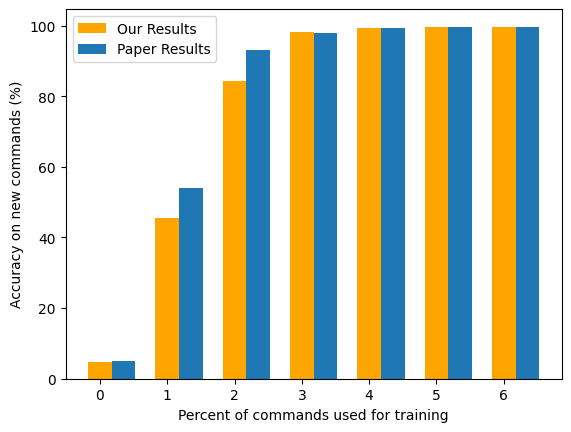

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
categories = ['1', '2', '4', '8%', '16%', '32%', '64%']
our_values = [4.76, 45.51, 84.39, 98.21, 99.4, 99.6, 99.7]
paper_values = [5, 54, 93, 98, 99.4, 99.65, 99.7]

# Set the width of the bars
bar_width = 0.35

# Calculate the positions for the bars
bar_positions1 = np.arange(len(categories))
bar_positions2 = bar_positions1 + bar_width

# Create the overlapping bar chart
plt.bar(bar_positions1, our_values, width=bar_width, color ='orange', label='Our Results')
plt.bar(bar_positions2, paper_values, width=bar_width, label='Paper Results')

# Create a bar graph
#plt.bar(categories, values)

# Add labels and title
plt.xlabel('Percent of commands used for training')
plt.ylabel('Accuracy on new commands (%)')

plt.legend()

# Display the graph
plt.show()